# Decision Support System (DSS) Span Analysis #

https://github.com/jupyter/docker-stacks  
https://hub.docker.com/r/jupyter/r-notebook/tags/  

_(optional) docker pull jupyter/r-notebook:latest_  

We want to make the DDS Prototype ~/analysis/ directory linked to the Juypter container. Use the following to mount the analysis directory (i.e. current working directory) as a volume in the Juypter container. Note that the directory needed to be added via the Docker Desktop Dashboard on Mac.

_docker run -it --rm -d -p 10000:8888 -v ${PWD}:/home/jovyan/work --name notebook jupyter/r-notebook:latest_  

To find the token from the container:  
_docker exec -it notebook jupyter server list_

Navigate to the container UI and enter the token:
http://localhost:10000

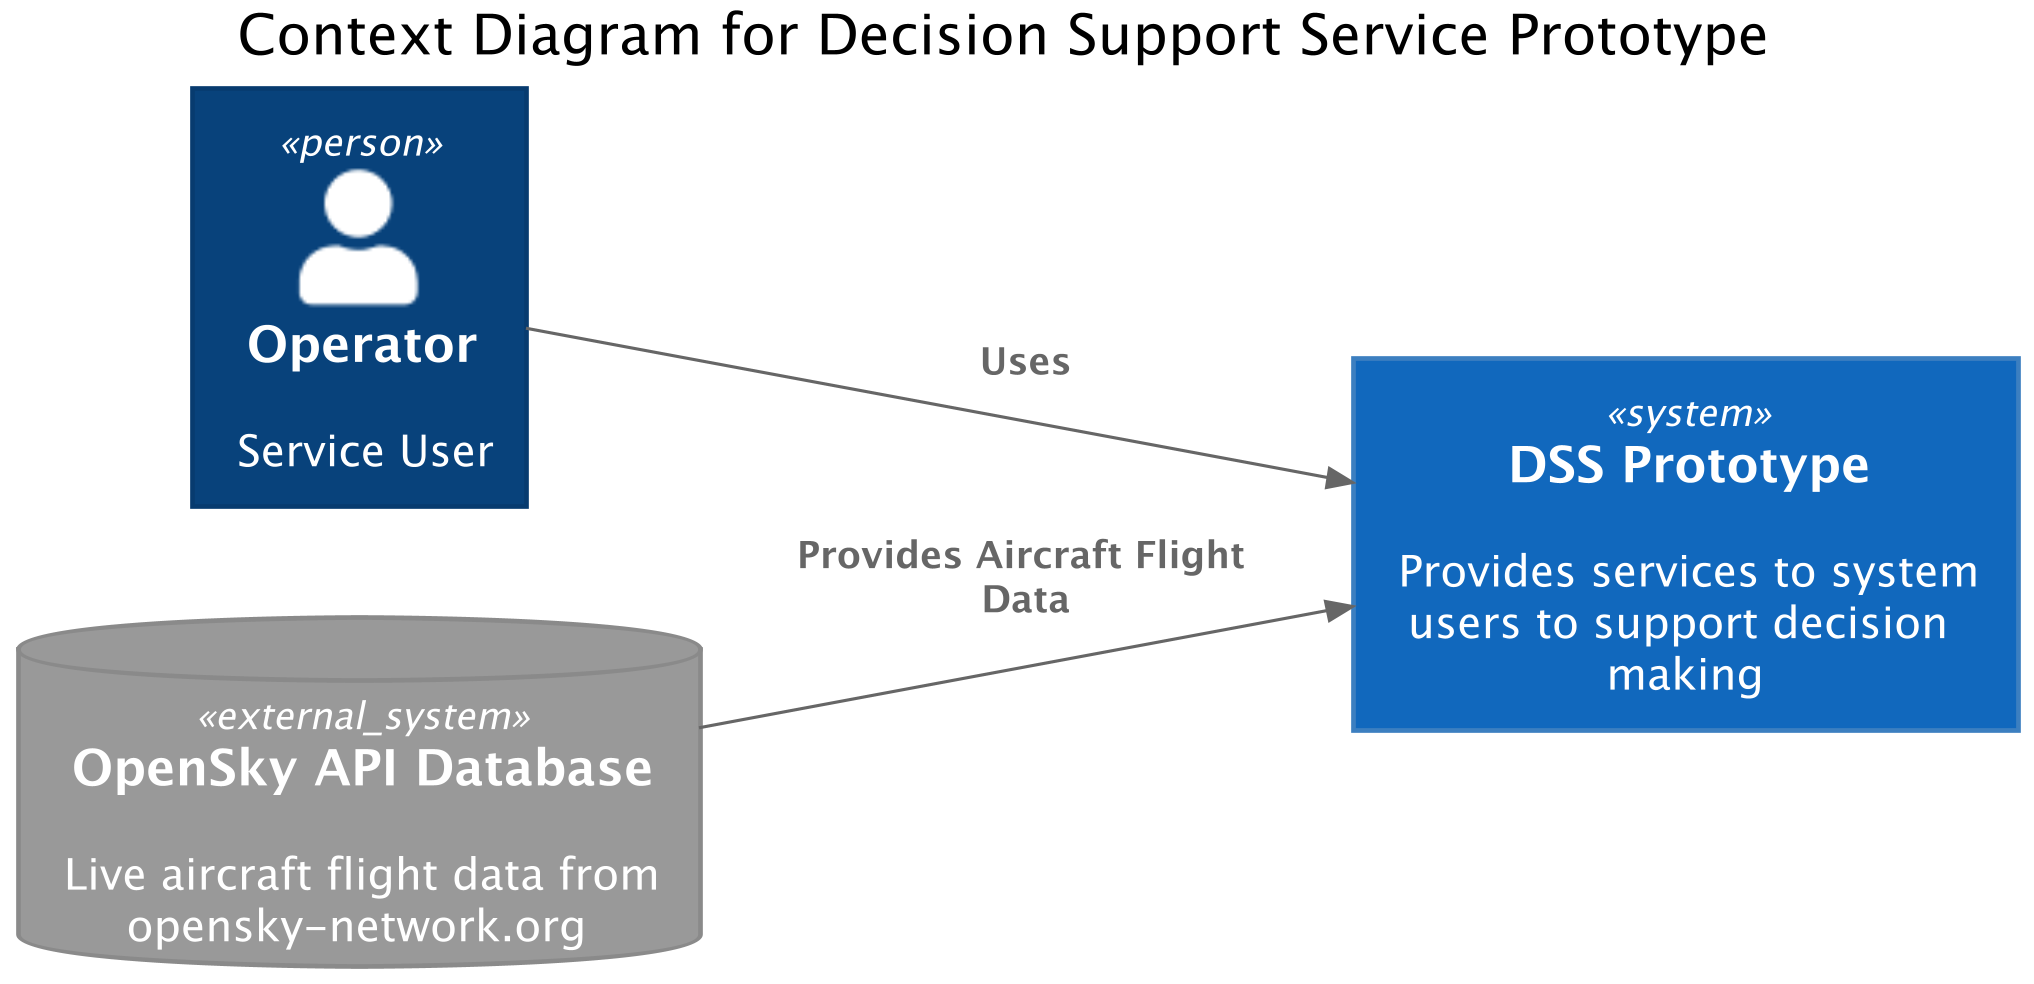

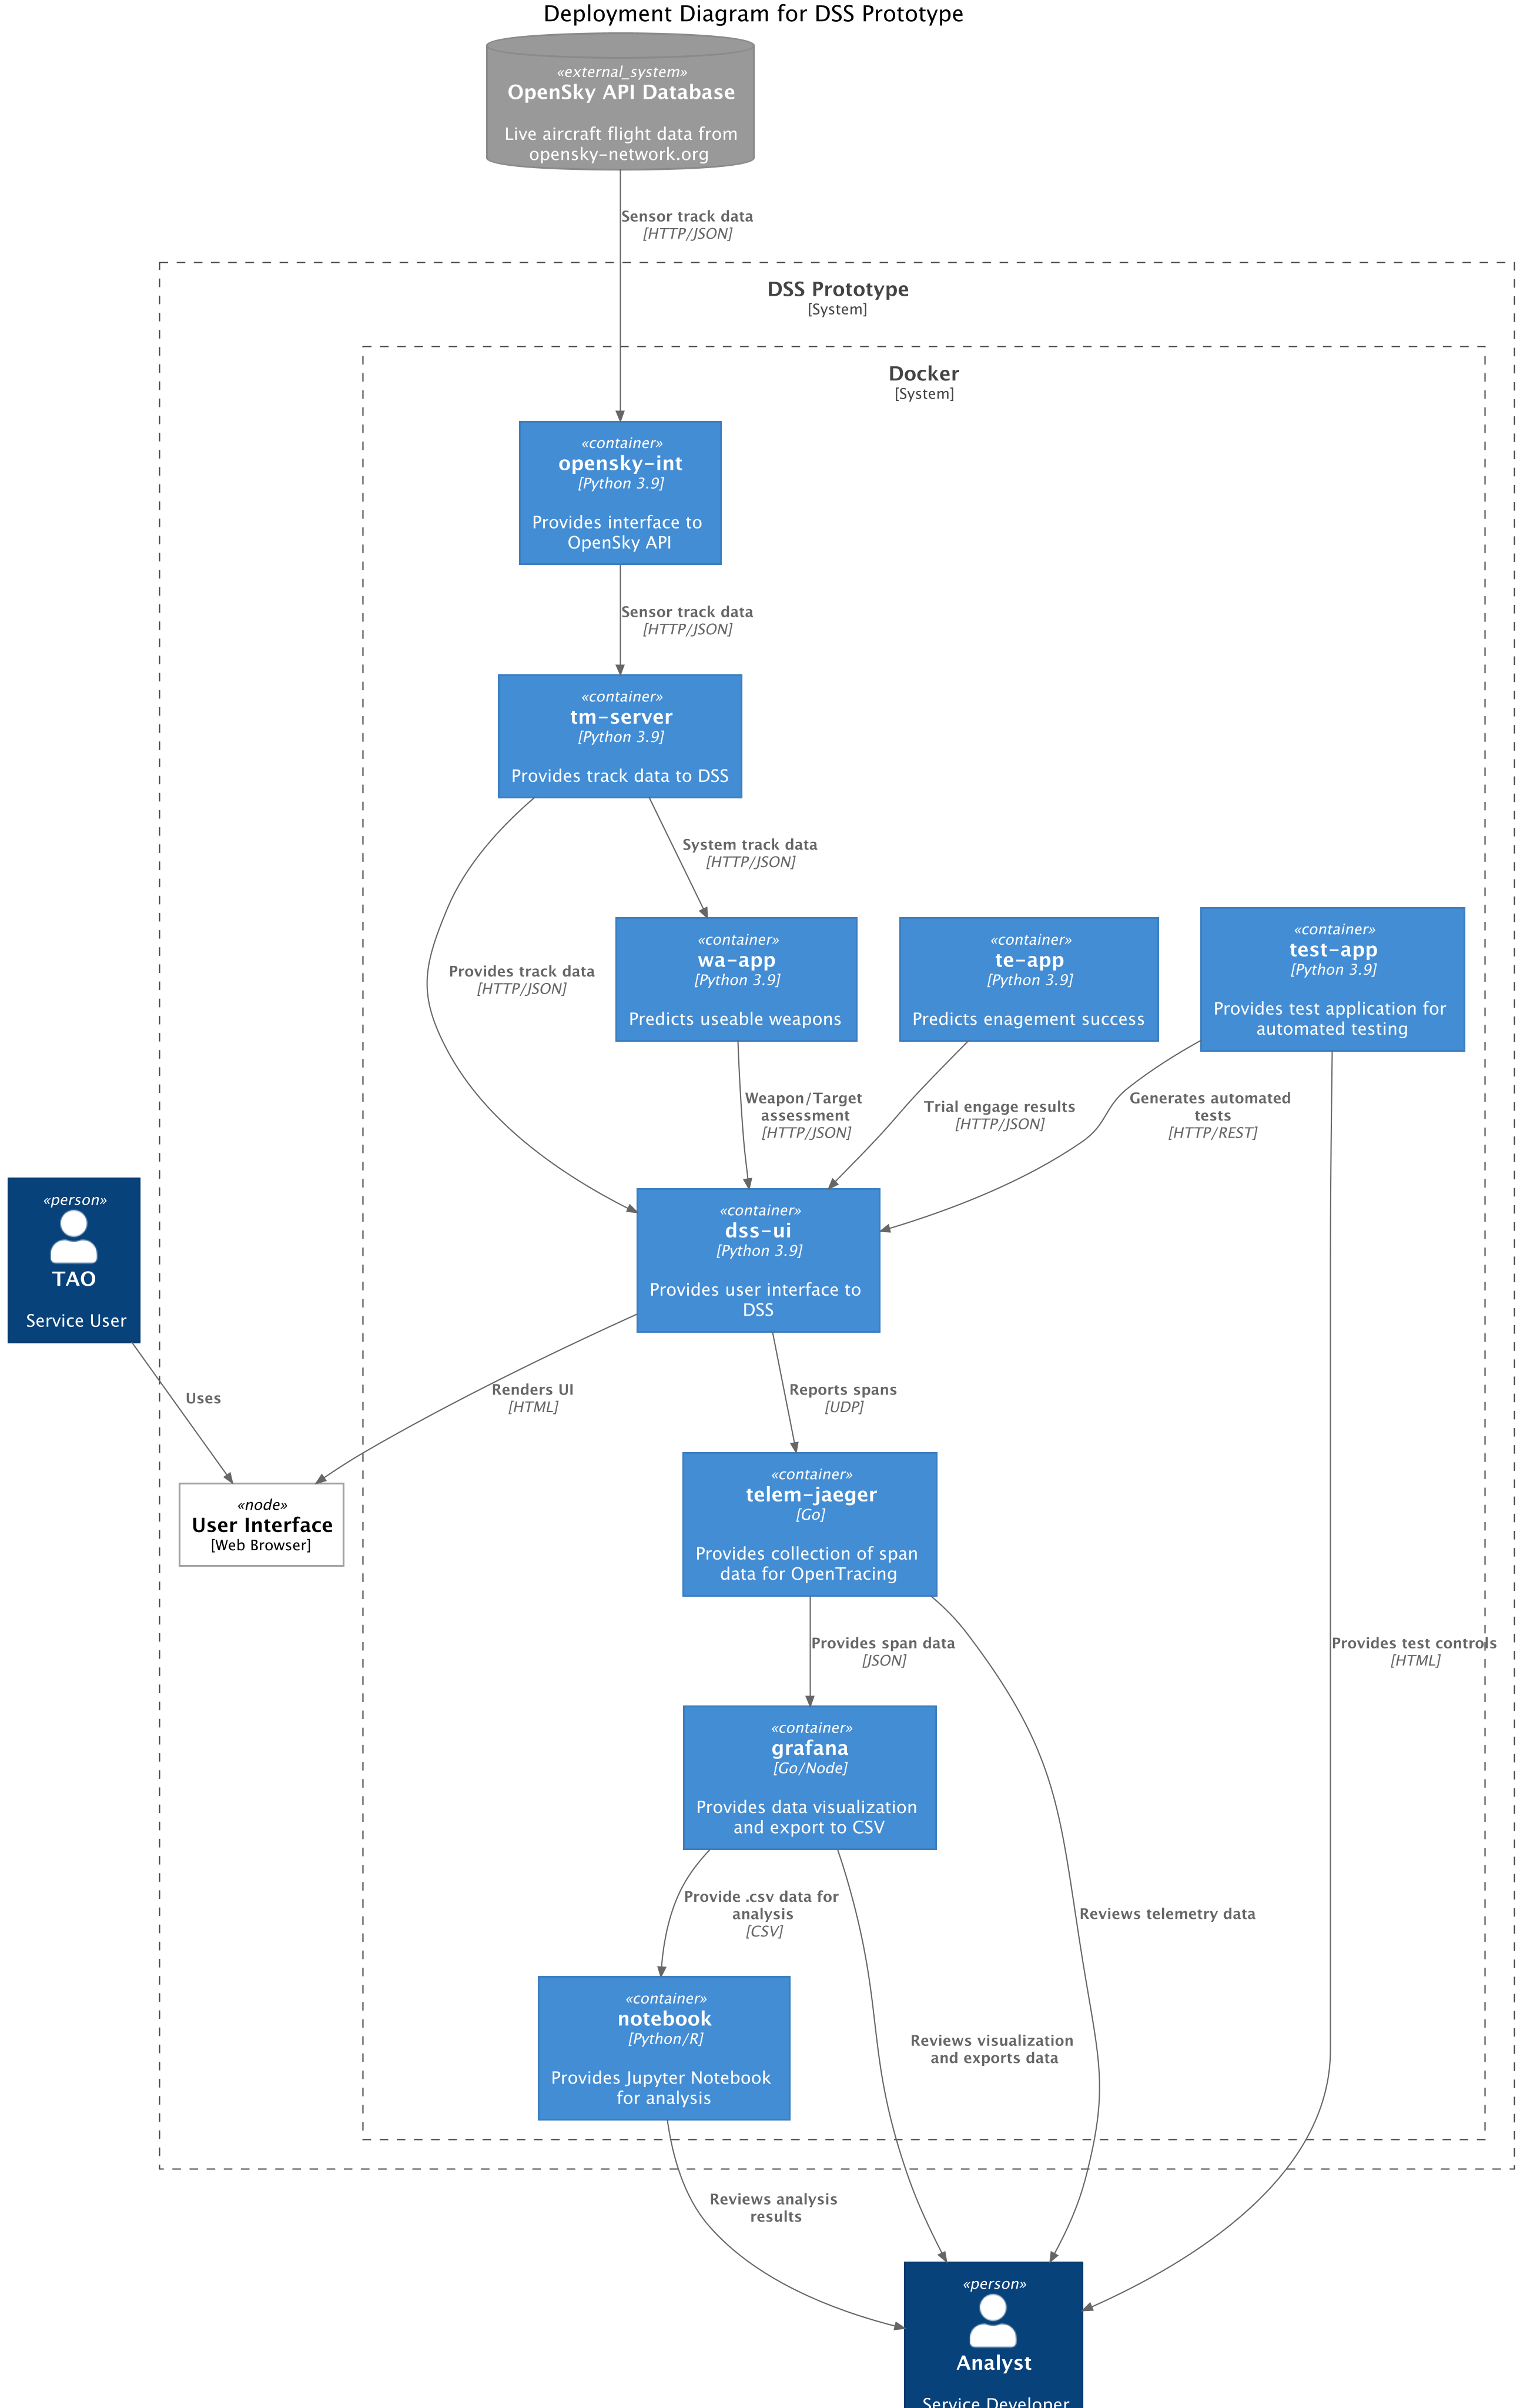

In [1]:
install.packages("stringr")                # Install packages and libraries in R
library("stringr")                       
# install.packages("dplyr")
# library("dplyr")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
setwd('/home/jovyan/work/data')

In [3]:
options(warn=-1)
spanData <- read.csv('DSS Span Data-data-2022-04-27 20_47_02.csv', header = TRUE)
attach(spanData)

# Exploratory Data Analysis #

In [4]:
head(spanData)

,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<chr>,<chr>
1,122166ffa2374e14a28214356ce62413,dss-prototype: /TE,2022-04-28 00:41:58.992,15.0 ms
2,34570c0676df9b5aa5988540c65859d4,dss-prototype: /tracks,2022-04-28 00:41:57.974,10.2 ms
3,14917cd1c56fa04a6e7a687da8e68c83,dss-prototype: /IAD,2022-04-28 00:41:56.380,586 ms
4,2fe2c53f4486d095fd1b08febe862f60,dss-prototype: /RIC,2022-04-28 00:41:54.811,559 ms
5,c84feac2ce994151ab4e52f141cce1cb,dss-prototype: /WA,2022-04-28 00:41:53.776,26.7 ms
6,a29dcffea1ba858c2b67376b6810b3a6,dss-prototype: /TE,2022-04-28 00:41:52.751,17.3 ms


In [5]:
summary(spanData)

   Trace.ID          Trace.name         Start.time          Duration        
 Length:100         Length:100         Length:100         Length:100        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

In [6]:
# Convert character data into numeric metrics

spanMetrics <- spanData

for(i in 1:nrow(spanMetrics)) {       # for-loop over rows
    
    # Convert span duration
    
    char = spanMetrics[i,4]
    len = str_length(char)
    duration = str_sub(char,1,(len-3))
    units = str_sub(char,(len-1),len)
    duration = as.numeric(duration)
    
    # print(duration)
    # print(units)

    if(units == 'ms') {
        duration = duration / 1000              # Convert to ms
    } else if (units == 'µs') {
        duration = duration / 1000000           # Convert to µs
    } else if (units == ' s') {
        duration = duration
    } else {
        print ('Unable to find specified units')
        print (units)
    }
    spanMetrics[i,4] = duration
    
    # Convert time

    time = spanMetrics[i,3]
    epoch <- as.POSIXct(time)
    epoch_int <- as.integer(epoch)
    spanMetrics[i,3] = epoch_int
}

# Convert columns for char to numeric

spanMetrics$Duration = as.numeric(spanMetrics$Duration)
spanMetrics$Start.time = as.numeric(spanMetrics$Start.time)

head(spanMetrics)
tail(spanMetrics)
summary(spanMetrics)

,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
1,122166ffa2374e14a28214356ce62413,dss-prototype: /TE,1651106518,0.0150
2,34570c0676df9b5aa5988540c65859d4,dss-prototype: /tracks,1651106517,0.0102
3,14917cd1c56fa04a6e7a687da8e68c83,dss-prototype: /IAD,1651106516,0.5860
4,2fe2c53f4486d095fd1b08febe862f60,dss-prototype: /RIC,1651106514,0.5590
5,c84feac2ce994151ab4e52f141cce1cb,dss-prototype: /WA,1651106513,0.0267
6,a29dcffea1ba858c2b67376b6810b3a6,dss-prototype: /TE,1651106512,0.0173


,Trace.ID,Trace.name,Start.time,Duration
,<chr>,<chr>,<dbl>,<dbl>
95,b1d8f4bf2b135bb5c523b0c2963f07bc,dss-prototype: /WA,1651106393,0.0375
96,1dfd0b58d0776253b0cc2b05bdf1abfe,dss-prototype: /TE,1651106392,0.0217
97,e69d05a6eb7c01b4cb64099b2834a14e,dss-prototype: /tracks,1651106391,0.0120
98,d2d5d182bbb39ce7109fe9e897229efa,dss-prototype: /IAD,1651106390,0.7370
99,cfaa3822d46e47570421f7c4a4444997,dss-prototype: /RIC,1651106388,0.5630
100,3c21bbf2ff4414a05e66d97d116d9225,dss-prototype: /WA,1651106387,0.0367


   Trace.ID          Trace.name          Start.time           Duration      
 Length:100         Length:100         Min.   :1.651e+09   Min.   :0.00815  
 Class :character   Class :character   1st Qu.:1.651e+09   1st Qu.:0.01597  
 Mode  :character   Mode  :character   Median :1.651e+09   Median :0.03340  
                                       Mean   :1.651e+09   Mean   :0.29897  
                                       3rd Qu.:1.651e+09   3rd Qu.:0.58650  
                                       Max.   :1.651e+09   Max.   :2.20000  

## Test for "Duration" Normality in the Original Data ##

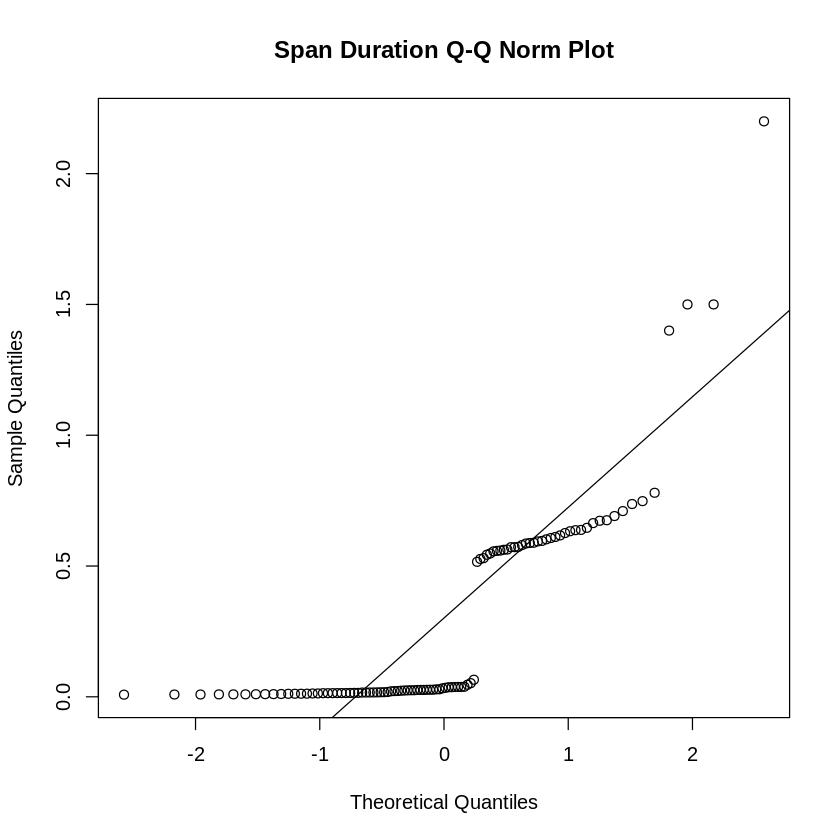

In [7]:
qqnorm(spanMetrics$Duration,main="Span Duration Q-Q Norm Plot")
qqline(spanMetrics$Duration)

A transformation is needed to apply statistical analysis.

# Clean the Data #

## Search for outliers

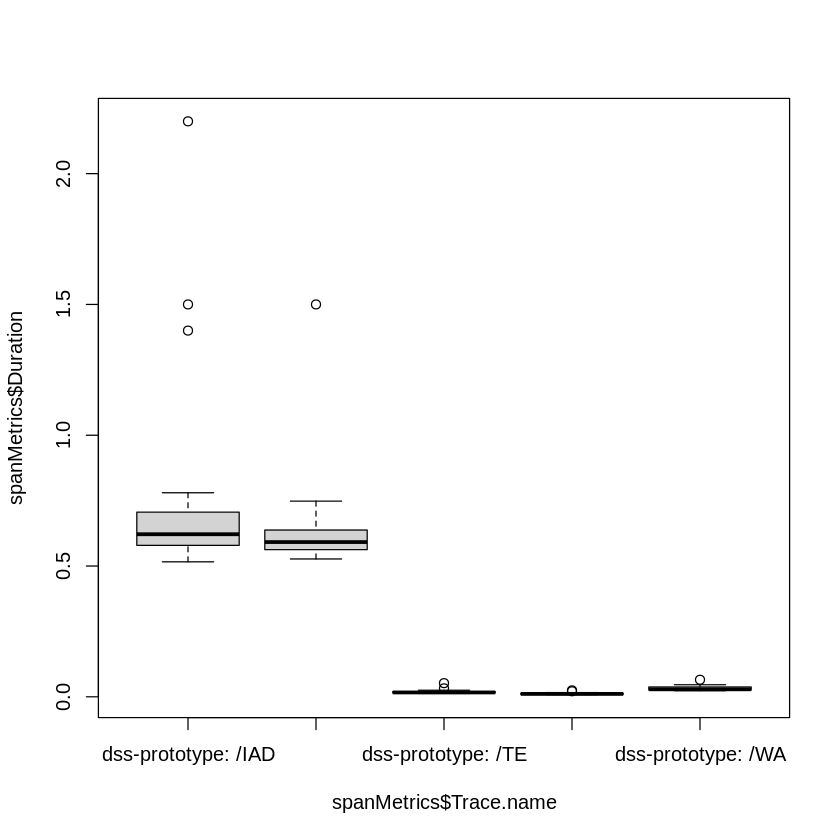

In [8]:
boxplot(spanMetrics$Duration~spanMetrics$Trace.name)

In [9]:
# Use this to get the values of the statistical outliers in trk_update_data from R
outliers <- boxplot(spanMetrics$Duration, plot = FALSE)$out
outliers

cleanMetrics <- spanMetrics
cleanMetrics <- cleanMetrics[-which(cleanMetrics$Duration %in% outliers),]

[1] 2.2 1.5 1.5

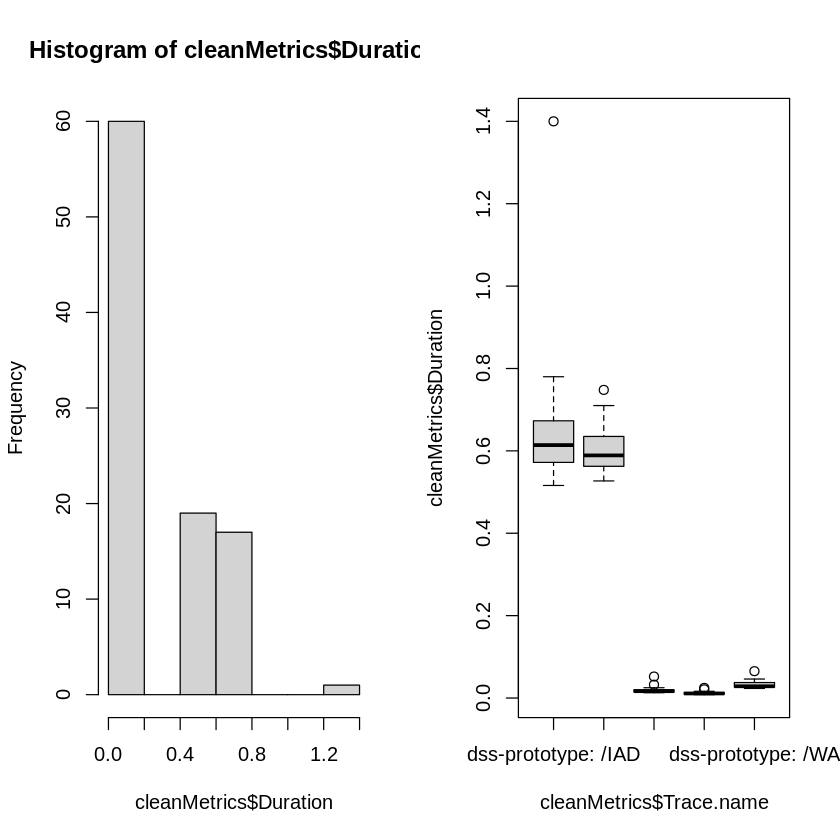

In [10]:
par(mfrow=c(1,2))
hist(cleanMetrics$Duration)
boxplot(cleanMetrics$Duration~cleanMetrics$Trace.name)

## Transformation of Clean Metrics

### Sqrt, Log, and Cube Transformations ###

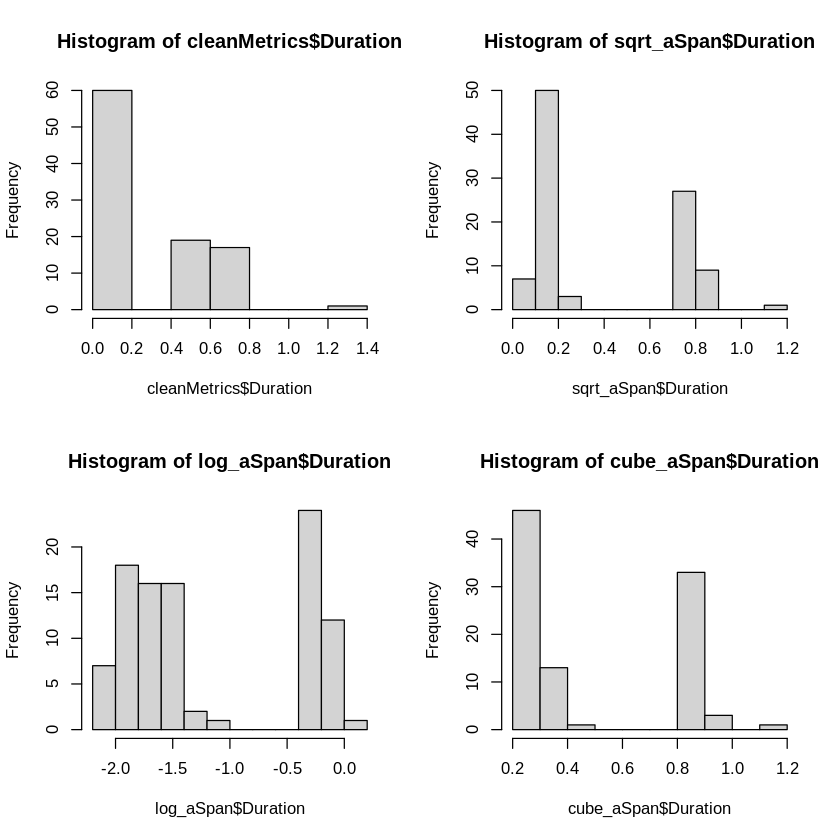

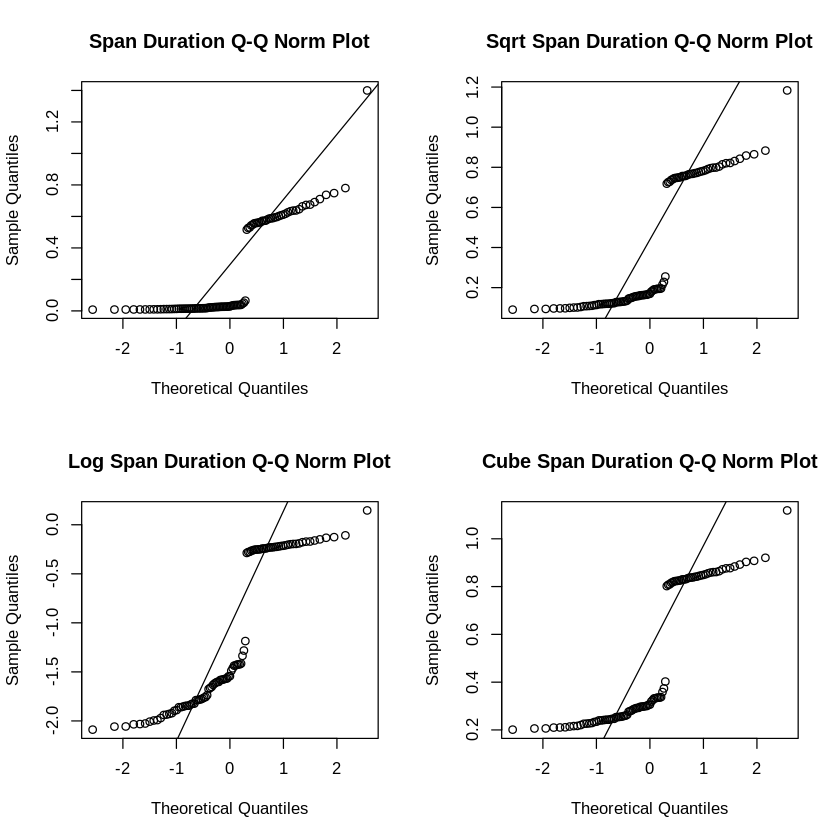

In [11]:
sqrt_aSpan <- cleanMetrics
sqrt_aSpan$Duration=sqrt(sqrt_aSpan$Duration)
log_aSpan <- cleanMetrics
log_aSpan$Duration=log10(log_aSpan$Duration)
cube_aSpan <- cleanMetrics
cube_aSpan$Duration=cube_aSpan$Duration^(1/3)

par(mfrow=c(2,2))
hist(cleanMetrics$Duration)
hist(sqrt_aSpan$Duration)
hist(log_aSpan$Duration)
hist(cube_aSpan$Duration)

par(mfrow=c(2,2))
qqnorm(cleanMetrics$Duration,main="Span Duration Q-Q Norm Plot")
qqline(cleanMetrics$Duration)
qqnorm(sqrt_aSpan$Duration,main="Sqrt Span Duration Q-Q Norm Plot")
qqline(sqrt_aSpan$Duration)
qqnorm(log_aSpan$Duration,main="Log Span Duration Q-Q Norm Plot")
qqline(log_aSpan$Duration)
qqnorm(cube_aSpan$Duration,main="Cube Span Duration Q-Q Norm Plot")
qqline(cube_aSpan$Duration)

None of these transformation yield distributions that would be considered normal. Most likely due to access to external and internal services with differing latency. Let try other transformations. 

### Box-Cox Transformation ###

Box and Cox (1964) developed a family of transformations designed to reduce nonnormality of the errors in a linear model. Applying this transform often reduces non-linearity as well, and heteroscedascity.

The idea is to transform the response variable $Y$ to a replacement response variable $Y_i^{(\lambda)}$, leaving the right-hand side of the regression model unchanged, so that the regression residuals become normally-distributed. Note that the regression coefficients will also change, because the response variable has changed; therefore, the regression coefficients must be interpreted with respect to the transformed variable. Also, any predictions made with the model have to be back-transformed, to be interpreted in the original units.

The standard (simple) Box-Cox transform is:

$$
    Y_i^{(\lambda)}=
\begin{cases}
{\frac {Y_i^\lambda - 1} \lambda},  & {(\lambda \neq 0)} \\
log(Y_i), & {(\lambda = 0)}
\end{cases}
$$

Box, G. E. P., & Cox, D. R. (1964). An Analysis of Transformations. Journal of the Royal Statistical Society, Series B (Metholodogical), 26(2), 211-252. 

http://www.css.cornell.edu/faculty/dgr2/_static/files/R_html/Transformations.html

In [12]:
library(MASS)

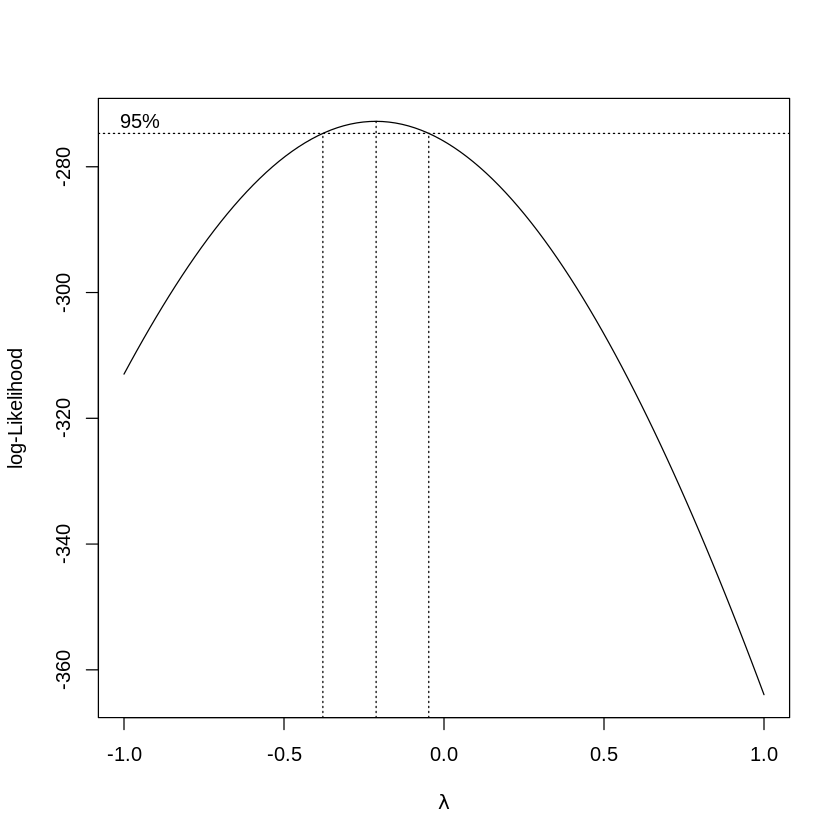

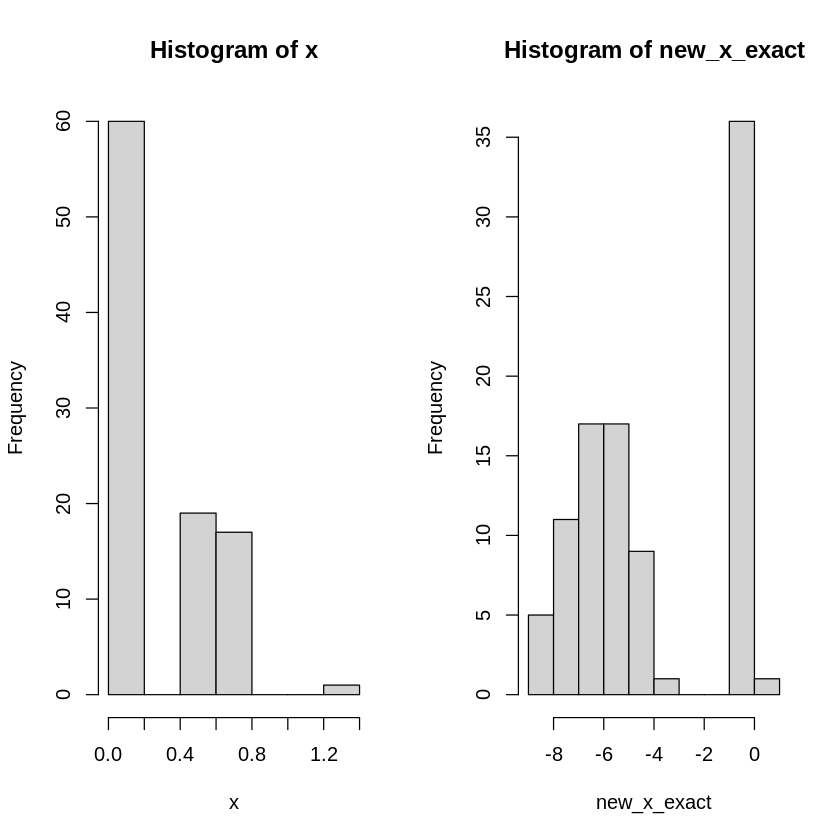

In [13]:
x <- cleanMetrics$Duration
bc = boxcox(lm(x ~ 1), seq(-1,1,.1))
#bc = boxcox(lm(x ~ 1))
lambda <- bc$x[which.max(bc$y)]
new_x_exact <- (x ^ lambda - 1) / lambda

par(mfrow=c(1,2))
hist(x)
hist(new_x_exact)

## Normality Testing of the Trasformation ##

### Shapiro-Wilk ###

The null-hypothesis of this test is that the population is normally distributed. Thus, if the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected (e.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population).

https://en.wikipedia.org/wiki/Shapiro–Wilk_test

In [14]:
shapiro.test(new_x_exact)


	Shapiro-Wilk normality test

data:  new_x_exact
W = 0.82749, p-value = 2.829e-09


With p-value of 2.829e-09 < 0.05 we reject the null hypothesis that the data are from a normally distributed population. But we'll also do a Q-Q Norm plot visually see the results.

### Q-Q Norm ###

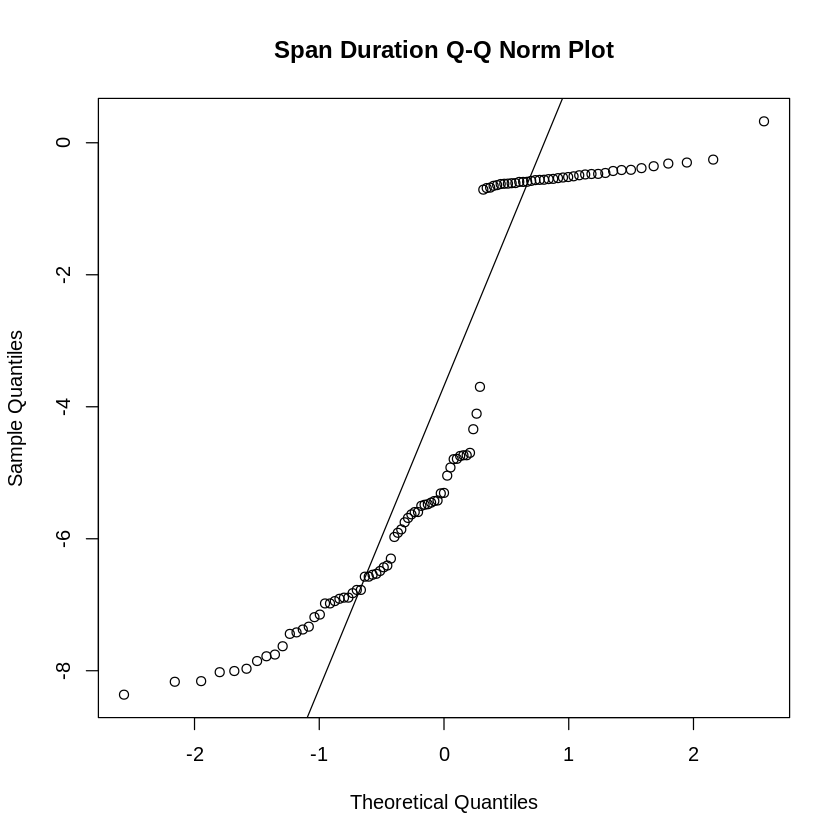

In [15]:
qqnorm(new_x_exact,main="Span Duration Q-Q Norm Plot")
qqline(new_x_exact)

Our assumption here is that the separation of lines is from the difference between internal and external span durations (e.g. latency). Let's see what happens when we split the samples.

# Splitting "Clean" Internal from External Data #

## Internal Data ##

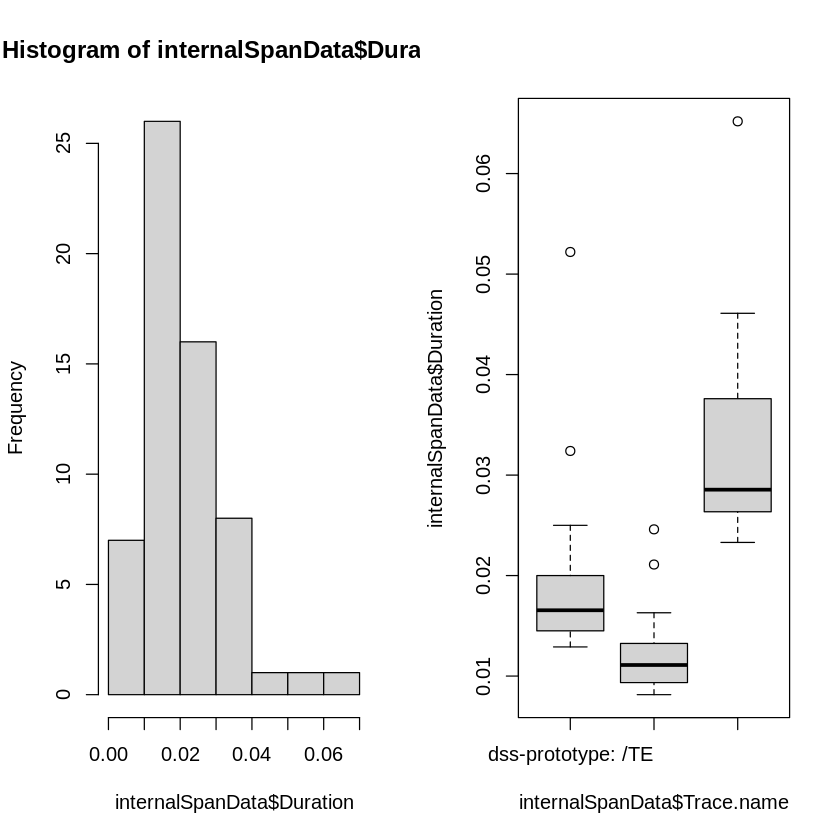

In [16]:
tracksSpanData = subset(cleanMetrics, Trace.name == "dss-prototype: /tracks")
TE_SpanData = subset(cleanMetrics, Trace.name == "dss-prototype: /TE")
WA_SpanData = subset(cleanMetrics, Trace.name == "dss-prototype: /WA")

internalSpanData <- rbind(tracksSpanData, TE_SpanData, WA_SpanData)
dssSpanData <- rbind(TE_SpanData, WA_SpanData)

# head(tracksSpanData)
# head(TE_SpanData)
# head(WA_SpanData)
# head(internalSpanData)

par(mfrow=c(1,2))
hist(internalSpanData$Duration)
boxplot(internalSpanData$Duration~internalSpanData$Trace.name)

This result looks much better.  However, we'll remove internal span outliers.

[1] 0.0522 0.0652

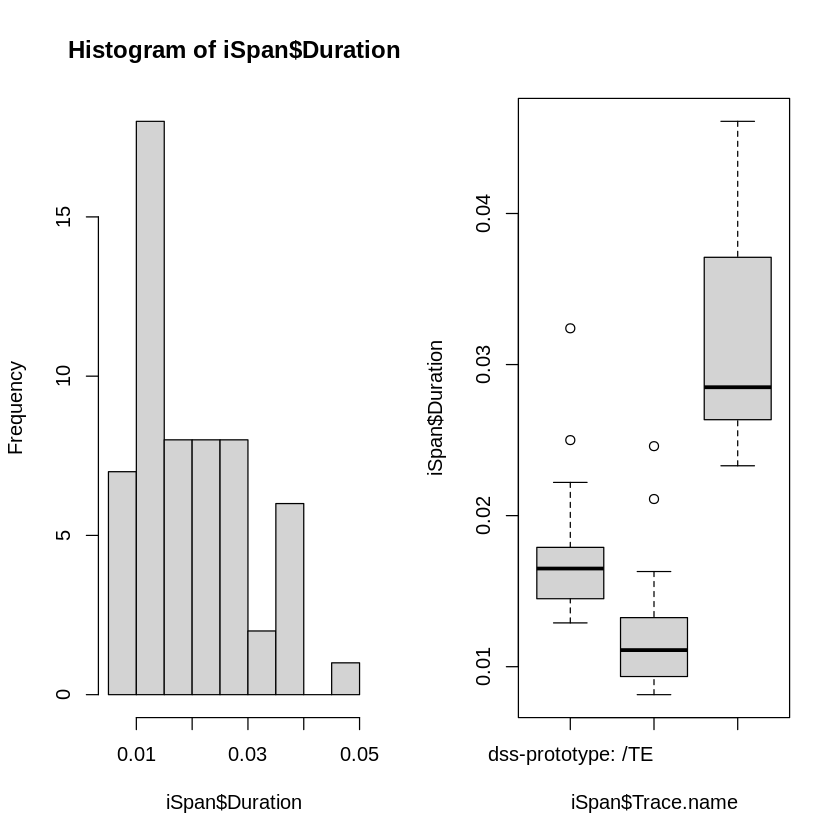

In [17]:
outliers <- boxplot(internalSpanData$Duration, plot = FALSE)$out
outliers

iSpan <- internalSpanData
iSpan <- iSpan[-which(iSpan$Duration %in% outliers),]

par(mfrow=c(1,2))
hist(iSpan$Duration)
boxplot(iSpan$Duration~iSpan$Trace.name)

### Q-Q Norm Plot of "Clean" Internal Span Data ###

We'll look a the Q-Q Norm Plot and Shapiro-Wilk Test

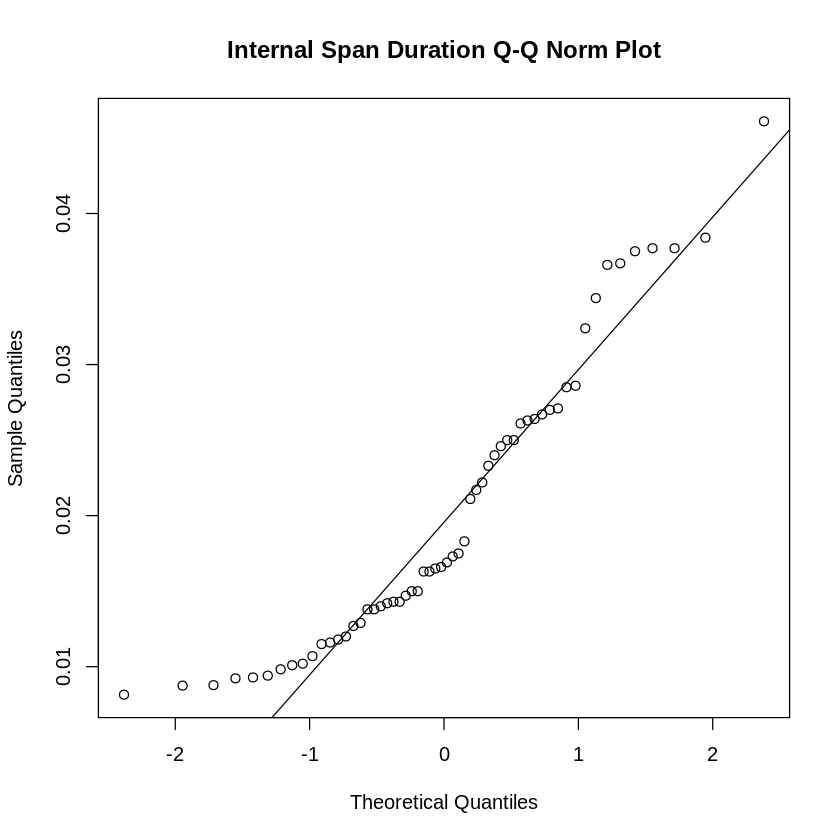

In [18]:
qqnorm(iSpan$Duration, main="Internal Span Duration Q-Q Norm Plot")
qqline(iSpan$Duration)

### Shapiro-Wilk Normality Test

In [19]:
shapiro.test(iSpan$Duration)


	Shapiro-Wilk normality test

data:  iSpan$Duration
W = 0.91154, p-value = 0.0004501


With p-value of 0.0004501 < 0.05 we reject the null hypothesis that the data are from a normally distributed population. 

### Data Transformations ###

#### Sqrt-Log-Cube Transformations ####

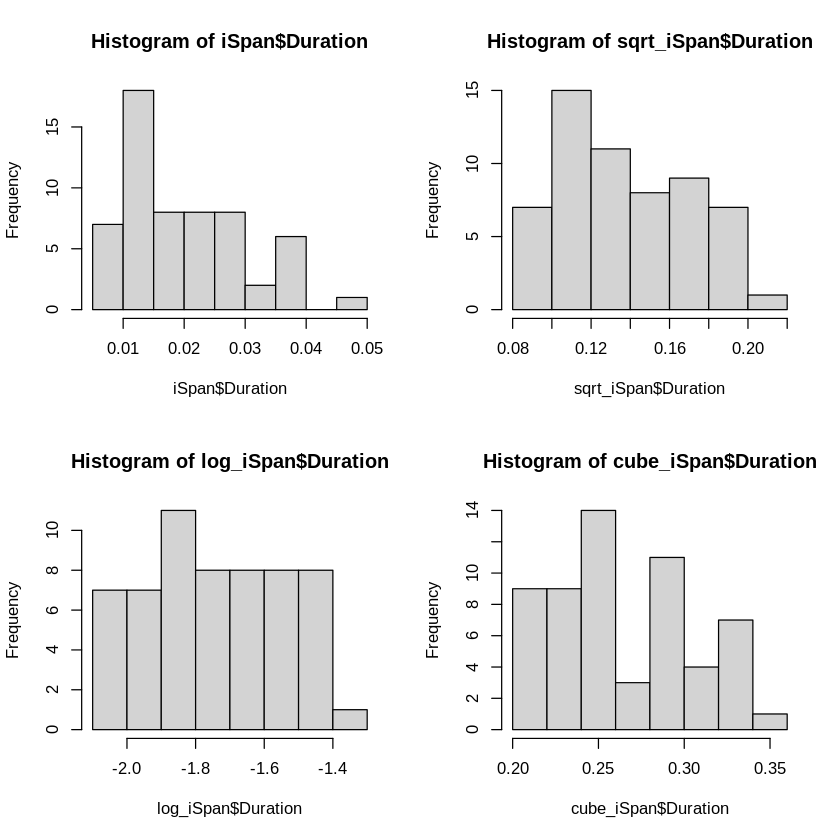

In [20]:
sqrt_iSpan <- iSpan
sqrt_iSpan$Duration=sqrt(sqrt_iSpan$Duration)
log_iSpan <- iSpan
log_iSpan$Duration=log10(log_iSpan$Duration)
cube_iSpan <- iSpan
cube_iSpan$Duration=cube_iSpan$Duration^(1/3)

par(mfrow=c(2,2))
hist(iSpan$Duration)
hist(sqrt_iSpan$Duration)
hist(log_iSpan$Duration)
hist(cube_iSpan$Duration)

#### Q-Q Norm Sqrt-Log-Cube ####

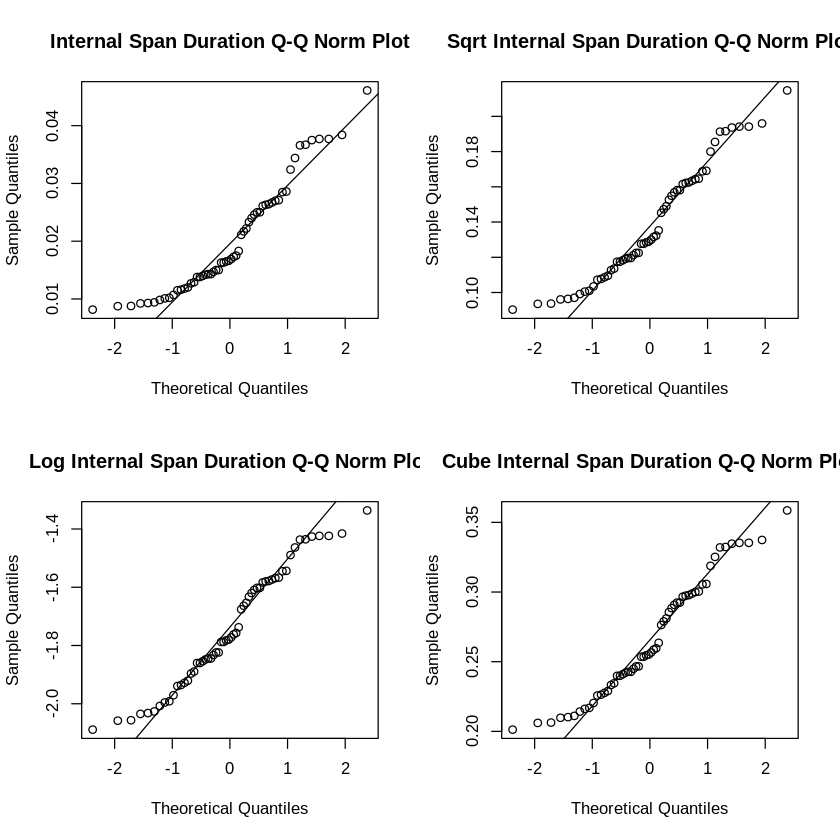

In [21]:
par(mfrow=c(2,2))
qqnorm(iSpan$Duration,main="Internal Span Duration Q-Q Norm Plot")
qqline(iSpan$Duration)
qqnorm(sqrt_iSpan$Duration,main="Sqrt Internal Span Duration Q-Q Norm Plot")
qqline(sqrt_iSpan$Duration)
qqnorm(log_iSpan$Duration,main="Log Internal Span Duration Q-Q Norm Plot")
qqline(log_iSpan$Duration)
qqnorm(cube_iSpan$Duration,main="Cube Internal Span Duration Q-Q Norm Plot")
qqline(cube_iSpan$Duration)

#### Shapiro-Wilk Testing Sqrt-Log-Cube ####

In [22]:
shapiro.test(sqrt_iSpan$Duration)
shapiro.test(log_iSpan$Duration)
shapiro.test(cube_iSpan$Duration)


	Shapiro-Wilk normality test

data:  sqrt_iSpan$Duration
W = 0.94291, p-value = 0.008706



	Shapiro-Wilk normality test

data:  log_iSpan$Duration
W = 0.95839, p-value = 0.04479



	Shapiro-Wilk normality test

data:  cube_iSpan$Duration
W = 0.94997, p-value = 0.01813


The **log transformation** with a p-value of 0.04479 is extremely close to > 0.05. Let's try Box-Cox.

#### Box-Cox Transformation ####

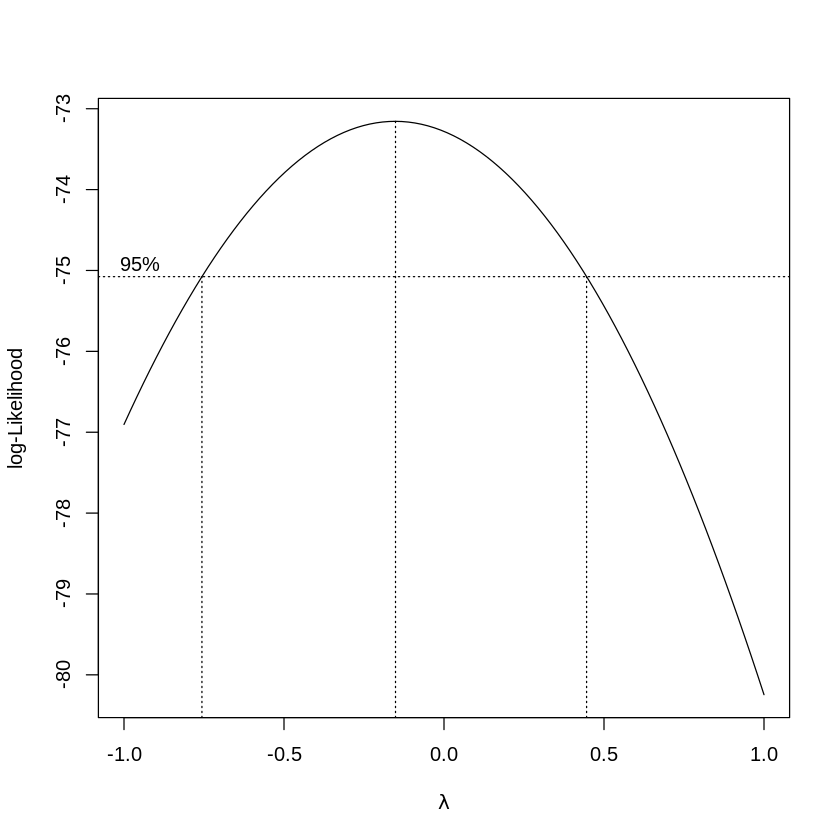

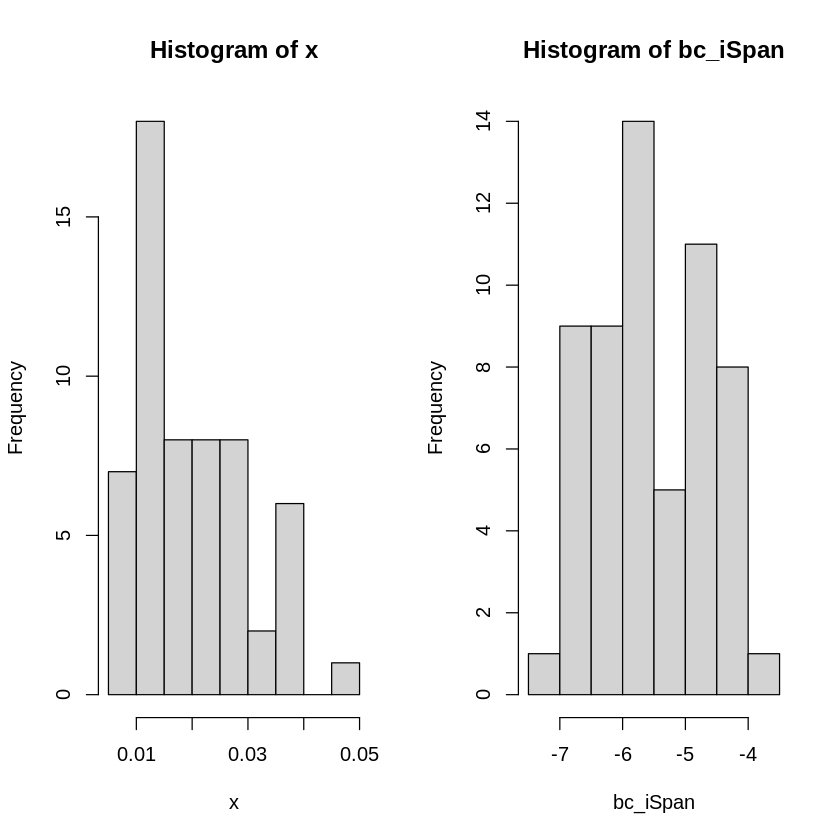

In [23]:
x <- iSpan$Duration
bc = boxcox(lm(x ~ 1), seq(-1,1,.1))
#bc = boxcox(lm(x ~ 1))
lambda <- bc$x[which.max(bc$y)]
bc_iSpan <- (x ^ lambda - 1) / lambda

par(mfrow=c(1,2))
hist(x)
hist(bc_iSpan)

#### Q-Q Norm Plot Box-Cox ####

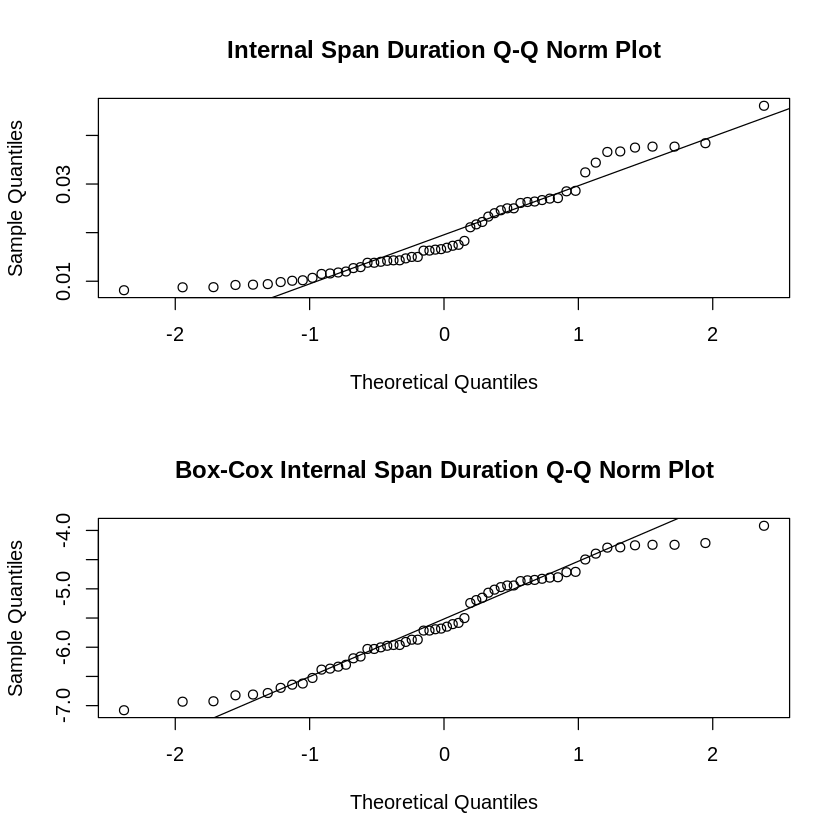

In [24]:
par(mfrow=c(2,1))
qqnorm(iSpan$Duration,main="Internal Span Duration Q-Q Norm Plot")
qqline(iSpan$Duration)
qqnorm(bc_iSpan,main="Box-Cox Internal Span Duration Q-Q Norm Plot")
qqline(bc_iSpan)

#### Shapiro-Wilk Test Box-Cox ####

In [25]:
shapiro.test(bc_iSpan)


	Shapiro-Wilk normality test

data:  bc_iSpan
W = 0.95962, p-value = 0.05123


With a Box-Cox transformation with a p-value of 0.05123 > 0.05 we fail to reject the null hypothesis, i.e. we assume that we now have a normal distribution.

### Hypothesis Testing of Transformed Internal Data ###

We will use a Student's t-Test to test the hypothesis on the internal span data.

In [26]:
x = bc_iSpan
t.test(x=x, mu=0.5, alternative = 'greater')


	One Sample t-test

data:  x
t = -53.64, df = 57, p-value = 1
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 -5.733583       Inf
sample estimates:
mean of x 
-5.545149 


## External Data ##

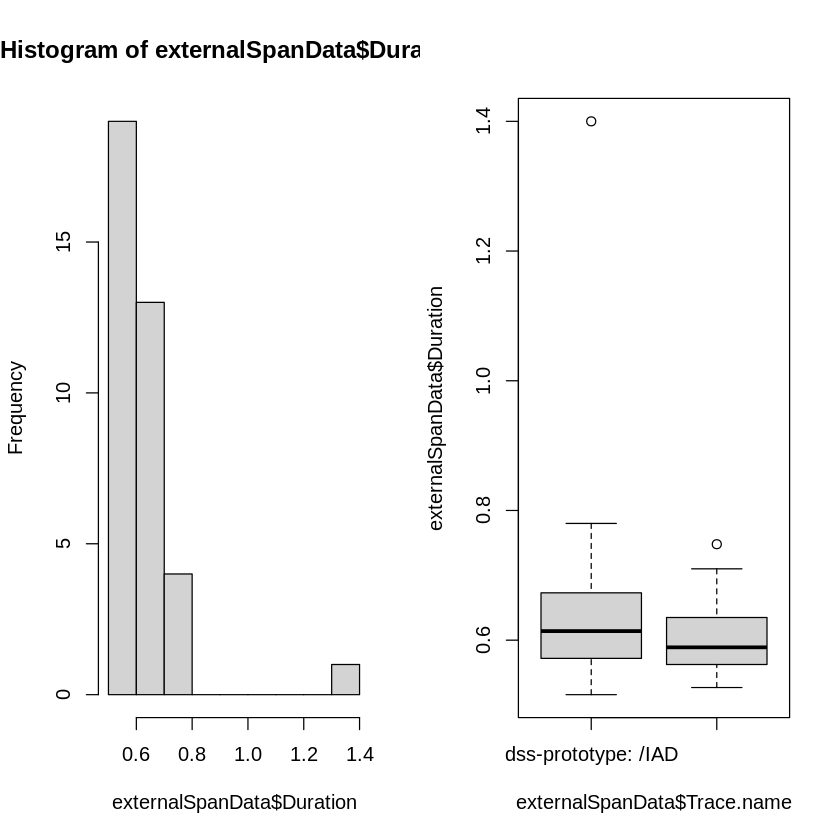

In [27]:
RIC_SpanData = subset(cleanMetrics, Trace.name == "dss-prototype: /RIC")
IAD_SpanData = subset(cleanMetrics, Trace.name == "dss-prototype: /IAD")

externalSpanData <- rbind(RIC_SpanData, IAD_SpanData)

# head(RIC_SpanData)
# head(IAD_SpanData)
# head(externalSpanData)

par(mfrow=c(1,2))
hist(externalSpanData$Duration)
boxplot(externalSpanData$Duration~externalSpanData$Trace.name)

[1] 0.78 1.40

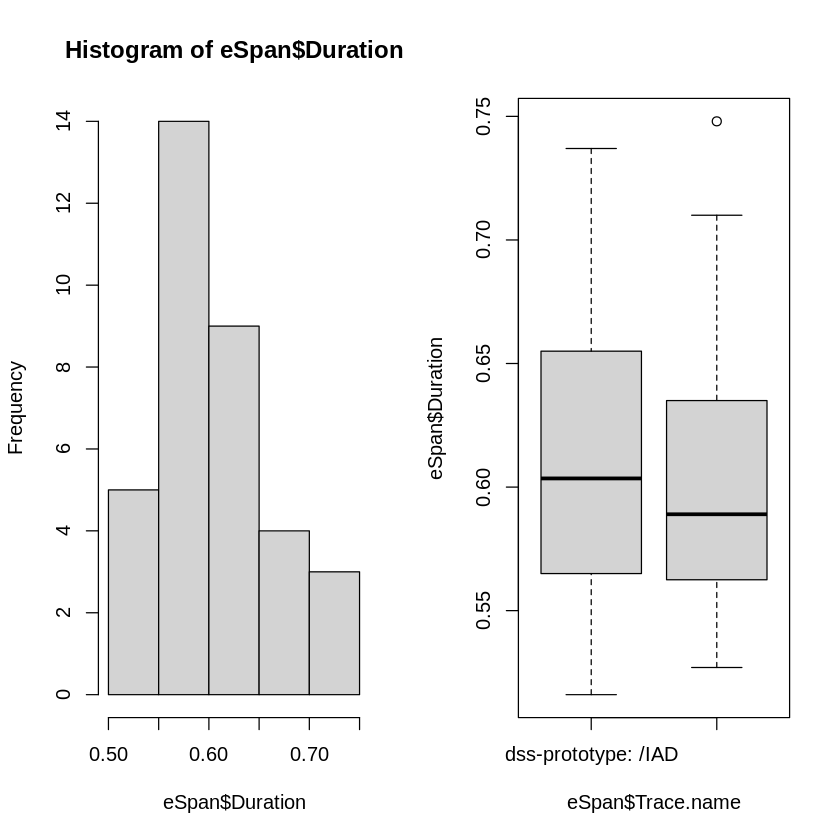

In [28]:
outliers <- boxplot(externalSpanData$Duration, plot = FALSE)$out
outliers

eSpan <- externalSpanData
eSpan <- eSpan[-which(eSpan$Duration %in% outliers),]

par(mfrow=c(1,2))
hist(eSpan$Duration)
boxplot(eSpan$Duration~eSpan$Trace.name)

### Q-Q Norm Plot of "Clean" External Span Data ###

We'll look a the Q-Q Norm Plot and Shapiro-Wilk Test

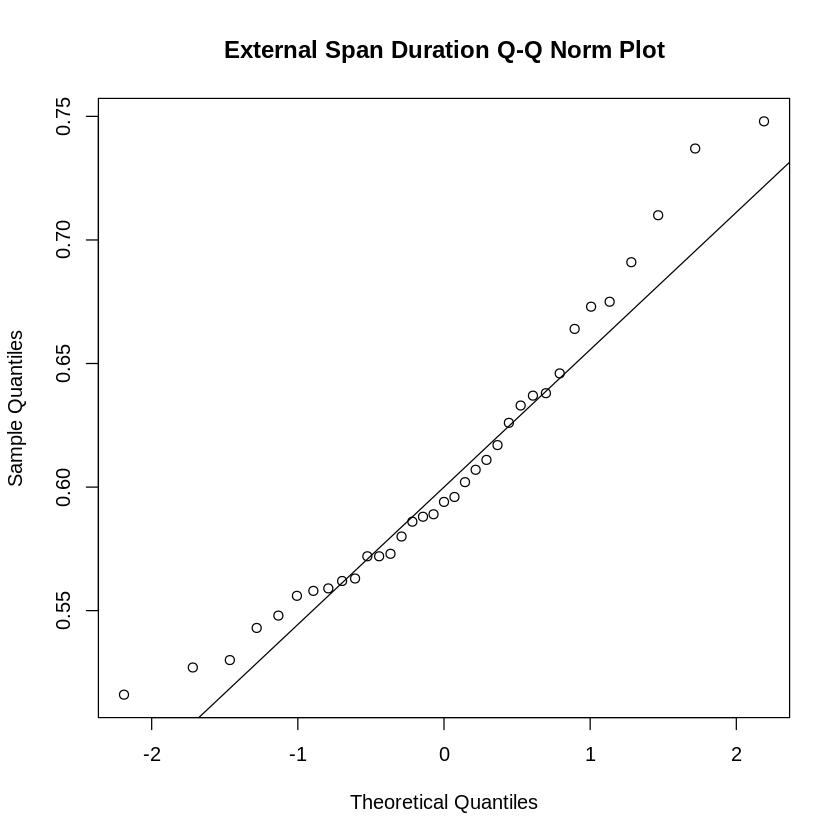

In [29]:
qqnorm(eSpan$Duration, main="External Span Duration Q-Q Norm Plot")
qqline(eSpan$Duration)

### Shapiro-Wilk Normality Test

In [30]:
shapiro.test(eSpan$Duration)


	Shapiro-Wilk normality test

data:  eSpan$Duration
W = 0.94743, p-value = 0.09445


With a p-value of 0.09445 > 0.05 we fail to reject the null hypothesis, i.e. we assume that we have a normal distribution. Data transformations are needed.


### Hypothesis Testing of External Data ###

We will use a Student's t-Test to test the hypothesis on the external span data.

In [31]:
x = eSpan$Duration
t.test(x=x, mu=0.5, alternative = 'greater')


	One Sample t-test

data:  x
t = 10.765, df = 34, p-value = 8.534e-13
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 0.58976     Inf
sample estimates:
mean of x 
0.6064857 


## Autocorrelation ##

Autocorrelation plots are a commonly-used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero.

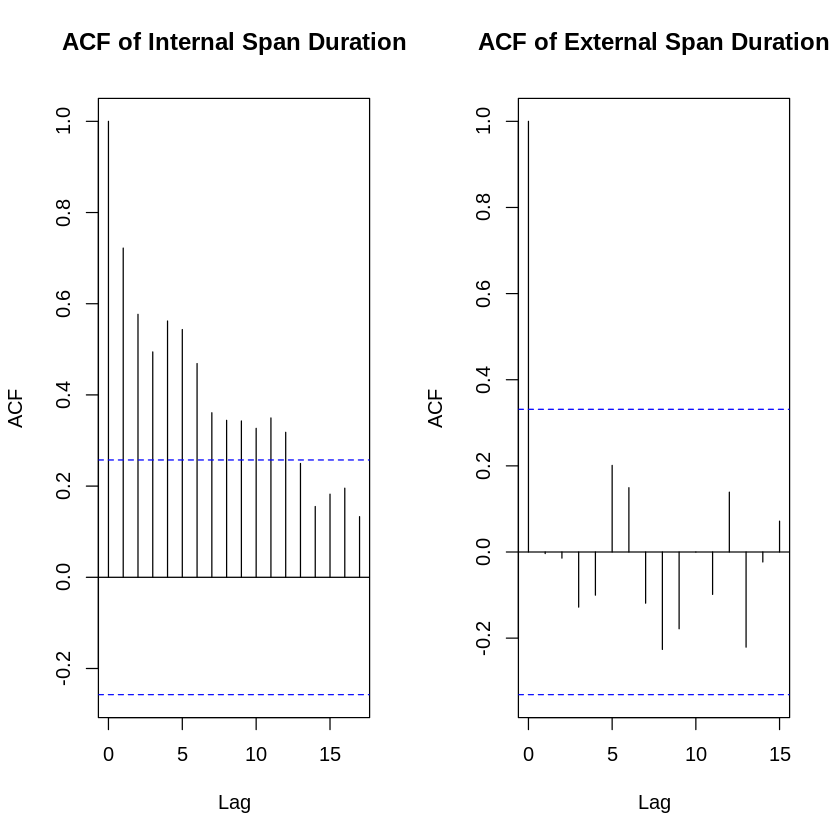

In [32]:
par(mfrow=c(1,2))
acf(iSpan$Duration, main="ACF of Internal Span Duration")
acf(eSpan$Duration, main="ACF of External Span Duration")

# Observations #

It was required to separate external data from internal to establish normality of the data samples. The internal data set required a Box-Cox Transformation to establish normality, while the external data set did not require a transformation. 

**Add Discussion of Hypothesis Results**